In [1]:
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string

In [2]:
directory_in_str = "C:\\Users\\Edward\\OneDrive\\Documents\\University\\Fourth Year\\Thesis\\Papers\\ExcelDataCollection\\Complete\\"
#print(directory_in_str)
directory = os.fsencode(directory_in_str)

COLUMN_NAMES=['TotalT','Temp','LSR','CA','Size','Mass','Moisture', 'IsoT', 'HeatT', 'Ramp', 'F_A', 'F_Gal', 'F_Glu',
            'F_X', 'F_M', 'F_R', 'A', 'Gal', 'Glu','X', 'M', 'R', 'Furf', 'HMF', 'Source']

masterDF = pd.DataFrame(columns=COLUMN_NAMES)
#print(len(masterDF.columns))
#print(masterDF.columns)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    absPath = directory_in_str + filename
    if filename.endswith(".xlsx"): 
        wb = load_workbook(filename = absPath, data_only = True) 
        ws = wb["Data"]
        ws.delete_rows(1,2)
        df = pd.DataFrame(ws.values, columns=COLUMN_NAMES[:-1])
        df['Source'] = filename
        #print("1", df.at[1, 'Temp'])
        masterDF = pd.concat([masterDF, df], ignore_index=True)
        #masterDF = masterDF.append(df)
        #print("2",masterDF.at[1, 'Temp'])
        continue
    else:
        continue
        
#masterDF = masterDF.astype(float)
masterDF.reset_index()


for i in masterDF.index:
    if masterDF.at[i, 'Ramp'] is None or pd.isnull(masterDF.at[i, 'Ramp']):
        masterDF.at[i, 'Ramp'] = (masterDF.at[i, 'Temp'] - 25) / masterDF.at[i, 'HeatT']
    if masterDF.at[i, 'HeatT'] is None or pd.isnull(masterDF.at[i, 'HeatT']):
        masterDF.at[i, 'HeatT'] = (masterDF.at[i, 'Temp'] - 25) / masterDF.at[i, 'Ramp']
    #print(type(masterDF.at[i, 'TotalT']))
    #print((masterDF.at[i, 'Temp']))
    if masterDF.at[i, 'TotalT'] is None or pd.isnull(masterDF.at[i, 'TotalT']):
        masterDF.at[i, 'TotalT'] =  masterDF.at[i, 'HeatT'] +  masterDF.at[i, 'IsoT']
    if masterDF.at[i, 'IsoT'] is None or pd.isnull(masterDF.at[i, 'IsoT']):
        masterDF.at[i, 'IsoT'] =  masterDF.at[i, 'TotalT'] -  masterDF.at[i, 'HeatT']
    if masterDF.at[i, 'TotalT'] == 0:
        masterDF.at[i, 'IsoT'] =  0
        masterDF.at[i, 'HeatT'] =  0
        
masterDF['TotalT'].fillna(masterDF.at[i, 'HeatT'] +  masterDF.at[i, 'IsoT'])


        
masterDF['X'].fillna(0, inplace=True)

#Converting Celsius to Kelvin
masterDF['Temp'] = masterDF['Temp'] + 273.15

#Making An Identifier Column to use instead of paper names
unique_papers = masterDF['Source'].unique()
paper_dict = dict(enumerate(unique_papers))
#swapping key and values
paper_dict = dict((v,k) for k,v in paper_dict.items())
alphabet = string.ascii_uppercase

masterDF['ID'] = masterDF['Source']
for i in masterDF.index:
    masterDF.at[i, 'ID'] = alphabet[paper_dict[masterDF.at[i, 'Source']]]

#This makes everything numeric
masterDF.to_csv("data.csv", index=False)
masterDF = pd.read_csv("data.csv")


#Creating Yield, Ro and P Factor
masterDF['Yield'] = 100 * masterDF['X'] * masterDF['LSR'] / (1000 * (masterDF['F_X']/100)) #1000 is density of water in g/L, X is in g/L

#P = exp(40.48 - 15106/T) * t, with T in Kelvin, t in hours
masterDF['P'] = np.exp(40.48 - 15106/masterDF['Temp']) * masterDF['IsoT']/60
masterDF['logP'] = masterDF['P']

#Ro = t * exp((T - 100)/14.75), t in minutes, T in Celsius
masterDF['Ro'] = masterDF['IsoT'] * np.exp(((masterDF['Temp'] -273.15) - 100)/14.75)
masterDF['logRo'] = masterDF['Ro']

for i in masterDF.index:
    if masterDF.at[i, 'logRo'] != 0:
        masterDF.at[i, 'logRo'] = np.log( masterDF.at[i, 'logRo'])
    if masterDF.at[i, 'logP'] != 0:
        masterDF.at[i, 'logP'] = np.log( masterDF.at[i, 'logP'])

masterDF.to_csv("data.csv", index=False)



(784, 31)


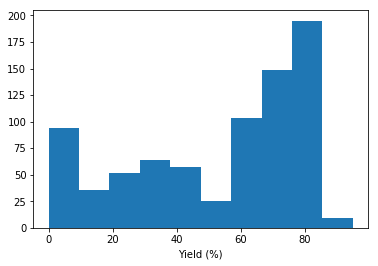

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

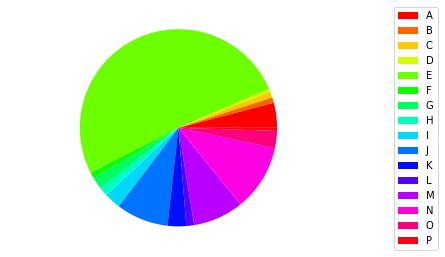

In [2]:
import matplotlib.patches

#Plotting Data
data = pd.read_csv("data.csv")

##Making new columns


targets = data['ID'].unique()
targets.sort()
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

colors = get_cmap(len(targets))
colors2 = []

for i in range(len(targets)):
    colors2.append((colors(i)))

X = data[['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']]
Y = data['X']

# print(data.head())
print(data.shape)
# print(data['Yield'].max())
#print(data['Yield'])

if None in data['Yield']:
    print(True)

#Plotting
fYield = plt.figure()
fTempvYield = plt.figure()
fAcidVYield = plt.figure()
fRoVYield = plt.figure()
fPVYield = plt.figure()
fDataSource = plt.figure()

axYield = fYield.add_subplot(111)
axYield.hist(data['Yield'])
# axYield.set_title("Histogram of Yield")
axYield.set_xlabel("Yield (%)")


fYield.savefig("YieldHist.png", dpi=600)

# axTempVYield = fTempvYield.add_subplot(111)
# axTempVYield.scatter(data['Temp'], data['Yield'])
# axTempVYield.set_title("Temp vs Yield")

# axAcidVYield = fAcidVYield.add_subplot(111)
# axAcidVYield.scatter(data['CA'], data['Yield'])
# axAcidVYield.set_title("Acid vs Yield")

# axRoVYield = fRoVYield.add_subplot(111)
# axRoVYield.scatter(data['logRo'], data['Yield'])
# axRoVYield.set_title("logRo vs Yield")

# axPVYield = fPVYield.add_subplot(111)
# axPVYield.scatter(data['logP'], data['Yield'])
# axPVYield.set_title("logP vs Yield")

sourceFreq = pd.value_counts(data['ID'])
sourceFreq = sourceFreq.sort_index()

axDataSource = fDataSource.add_subplot(111)

explode = [0.01] * len(colors2)
axDataSource.pie(sourceFreq.values, colors=colors2)
# axDataSource.set_title("Distribution of Data by Source")
axDataSource.axis('equal')
labels = sourceFreq.axes[0]


# handles = []
# for i, l in enumerate(labels):
#     handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i)/8.), label=l))
# axDataSource.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")

axDataSource.legend(labels, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

fDataSource.savefig("DistributionOfData.png", dpi=600, bbox_inches='tight')

plt.show()

print()


In [4]:
# # axTempVYield = fTempvYield.add_subplot(111)
# # axTempVYield.scatter(data['Temp'], data['Yield'])
# # axTempVYield.set_title("Temp vs Yield")

# # axAcidVYield = fAcidVYield.add_subplot(111)
# # axAcidVYield.scatter(data['CA'], data['Yield'])
# # axAcidVYield.set_title("Acid vs Yield")

# # axRoVYield = fRoVYield.add_subplot(111)
# # axRoVYield.scatter(data['logRo'], data['Yield'])
# # axRoVYield.set_title("logRo vs Yield")

# # axPVYield = fPVYield.add_subplot(111)
# # axPVYield.scatter(data['logP'], data['Yield'])
# # axPVYield.set_title("logP vs Yield")

# sourceFreq = pd.value_counts(data['ID'])
# sourceFreq = sourceFreq.sort_index()

# axDataSource = fDataSource.add_subplot(111)
# axDataSource.pie(sourceFreq.values)
# axDataSource.set_title("Distribution of Data by Source")
# axDataSource.axis('equal')
# labels = sourceFreq.axes[0]


# # handles = []
# # for i, l in enumerate(labels):
# #     handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i)/8.), label=l))
# # axDataSource.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")

# axDataSource.legend(labels, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
#            bbox_transform=plt.gcf().transFigure)

# plt.savefig("DistributionOfData.png", dpi=600)

# plt.show()

In [3]:
#Prepping Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


data = data.sample(frac=1).reset_index(drop=True)
XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
# y = data['Yield']

#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)  

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

# print(len(X_train), len(X_test), len(X_valid))
# print(X_train)

# plt.hist(y_train)

numData = len(data.index)
numTrain = int(numData * 0.7)
numTest = int(numData * .15) 
# print(numTest, numTrain)
train_Frame, valid_Frame, test_Frame, train_valid_Frame = data.iloc[:numTrain, :], data.iloc[numTrain:-numTest, :], data.iloc[-numTest:, :], data.iloc[:-numTest:, :]


#Calculating Sample Weight
bins = train_Frame['Yield'].value_counts(bins=10)

for i in train_Frame.index:
    for j in bins.index:
        if int(train_Frame.at[i, 'Yield']) in j:
            train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
            
bins = train_valid_Frame['Yield'].value_counts(bins=10)

for i in train_valid_Frame.index:
    for j in bins.index:
        if int(train_valid_Frame.at[i, 'Yield']) in j:
            train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()



#print(train_Frame.head())

y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']

X_train, X_valid, X_test, X_train_valid = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :], X[:-numTest, :]

train_weights = train_Frame['Sample_Weight']
train_valid_weights = train_valid_Frame['Sample_Weight']




C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
average 48.061405914029486
Mean Absolute Error: 13.204757127150977
Mean Squared Error: 299.48308479796043
Root Mean Squared Error: 17.30557958572785
Coefficients:  [ -0.34386686 -16.4705989    3.74356875   8.69265271  -0.20686358
  12.53729176   1.26786609  -7.997649     5.74904775  -9.39815208
 -58.0561638   14.86937246  55.28665242]


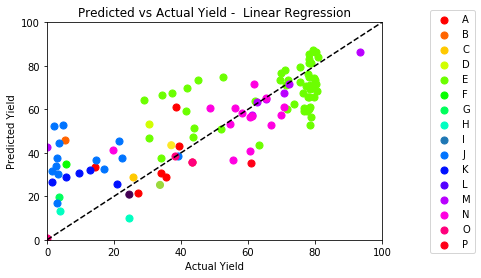

In [5]:
#Multiple Linear Regression Simple
from sklearn import linear_model
import statsmodels.api as sm
from sklearn import metrics

# with sklearn

# print(type(X_train))
# np.savetxt("temp.csv", X_train)
print(type(X_train), type(y_train))


# print(np.isnan(X_train))
np.argwhere(np.isnan(X_train))
#print(X_train)

regr = linear_model.LinearRegression()
# regr.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights)
regr.fit(X_train_valid, y_train_valid)

coeffs = dict(zip(XLabels, regr.coef_))

# print("results of SKLearnLinearRegression----------------")
# print('Intercept: \n', regr.intercept_)
# print('Coefficients: \n', coeffs)
# print('Score', regr.score(X,Y))
y_pred = regr.predict(X_test)


predAndActual = pd.DataFrame({'Pred' : y_pred, 'Test': y_test})
predAndActual.to_csv("OverallSimpleLinear.csv")


print('average', y_test.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Coefficients: ", regr.coef_)

error_arr = abs(y_test - y_pred)
#plt.hist(error_arr)
#plt.scatter(y_test, y_pred)


for index, target in enumerate(targets):
    indicesToKeep = test_Frame['ID'] == target
    plt.scatter(y_test.values[indicesToKeep]
               , y_pred[indicesToKeep]
               , c = colors(index)
               , s = 50)
    
t = np.linspace(0, 100, 400)
line = t
plt.legend(targets, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.plot(t, line, 'k', ls='dashed')


# plt.ylim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
# plt.xlim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
plt.ylim(0, 100)
plt.xlim(0, 100)

plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield -  Linear Regression")
plt.savefig("LinearRegression.png", dpi=600, bbox_inches='tight')


C:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.72628e-17): result may not be accurate.
  overwrite_a=True).T


best alpha is:  0.1
Lowest Error In Validation _MSE_  11.56380034490426
average 50.16002264477028
Mean Absolute Error: 12.700049669087276
Mean Squared Error: 264.839316150037
Root Mean Squared Error: 16.273884482508684
Coefficients:  [ -0.21919803 -16.26214478   4.43732762   8.57322429  -0.34406958
  13.36983872   1.3630954   -7.81000387   6.94888003  -9.94096347
 -52.48501693  14.38671541  49.70153868]


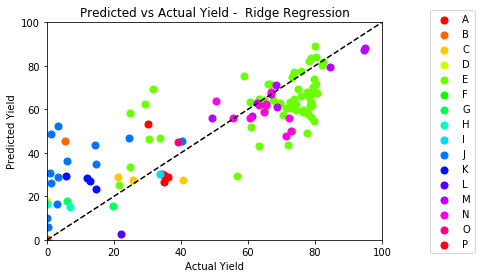

In [7]:
#Linear Least Square with I2 regularization
#Ridge
from sklearn.linear_model import Ridge
from sklearn import metrics


#alphas = [0]
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]
errors = []

#Creating Different models for different alphas
for a in alphas:
    ridgeModel = Ridge(alpha=a)
    ridgeModel.fit(X_train, y_train) 
    y_pred = ridgeModel.predict(X_valid)
    error =  metrics.mean_absolute_error(y_valid, y_pred)
    errors.append(error)
    

best_alpha = alphas[np.argmin(errors)]
print("best alpha is: ",best_alpha)
print("Lowest Error In Validation _MSE_ ", np.min(errors))

best_model = Ridge(alpha=best_alpha)
# best_model.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights)
best_model.fit(X_train_valid, y_train_valid)
y_pred = best_model.predict(X_test)


predAndActual = pd.DataFrame({'Pred' : y_pred, 'Test': y_test})
predAndActual.to_csv("OverallRidge.csv")
    
#Evaluation
print('average', y_test.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Coefficients: ", best_model.coef_)

error_arr = abs(y_test - y_pred)
#plt.hist(error_arr)
#plt.scatter(y_test, y_pred)

for index, target in enumerate(targets):
    indicesToKeep = test_Frame['ID'] == target
    plt.scatter(y_test.values[indicesToKeep]
               , y_pred[indicesToKeep]
               , c = colors(index)
               , s = 50)
    
t = np.linspace(0, 100, 400)
line = t


plt.legend(targets, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.plot(t, line, 'k', ls='dashed')


# plt.ylim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
# plt.xlim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
plt.ylim(0, 100)
plt.xlim(0, 100)

plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield -  Ridge Regression")
plt.savefig("Ridge", dpi=600, bbox_inches='tight')



Lowest Error In Validation _MSE_  6.027224208513725
Best kernel is:  rbf
Best Epsilon is:  0.1
Best C is:  20
Best Gamma is:  scale
average 50.16002264477028
Mean Absolute Error: 6.215053450246141
Mean Squared Error: 112.66010704066785
Root Mean Squared Error: 10.61414655262814


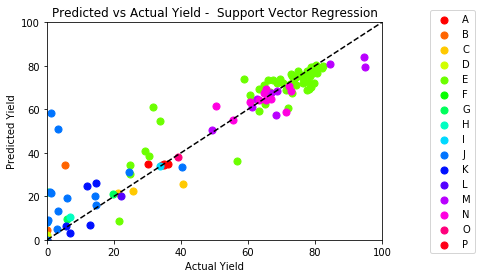

In [8]:
#SVM Models
from sklearn.svm import SVR


kernels =  ['poly', 'rbf', 'linear']
epsilons = [0.1,5,10, 20]
Cs = [0.1,1,10, 20]
gammas = ['scale', 'auto']
errors = []

for kern in kernels:
    for ep in epsilons:
        for C_ in Cs:
            for gam in gammas:
                svrModel = SVR(kernel=kern, gamma=gam, epsilon=ep, cache_size=2000, C=C_)
#                 svrModel.fit(X_train, y_train, sample_weight=train_weights)
                svrModel.fit(X_train, y_train)
                y_pred = svrModel.predict(X_valid)
                error =  metrics.mean_absolute_error(y_valid, y_pred)
                errors.append(error)
        

index_of_lowest_error = np.argmin(errors)
print("Lowest Error In Validation _MSE_ ", np.min(errors))

best_kernel = kernels[int(index_of_lowest_error / (len(epsilons) * len(Cs) * len(gammas)))] #Good
best_ep = epsilons[int((index_of_lowest_error % (len(epsilons) *len(Cs) * len(gammas)))/(len(Cs) *len(gammas)))] #Good
best_C = Cs[int((index_of_lowest_error % (len(Cs) * len(gammas)))/len(gammas))] #Good 
best_gamma = gammas[i % len(gammas)]

print("Best kernel is: ", best_kernel)
print("Best Epsilon is: ", best_ep)
print("Best C is: ", best_C)
print("Best Gamma is: ", best_gamma)


# # Make it run a little faster, hardcode best
# best_kernel = 'rbf'
# best_ep = 5
# best_C = 20
# best_gamma = 'auto'


best_model = SVR(kernel=best_kernel, gamma=best_gamma, epsilon=best_ep, cache_size=2000, C=best_C)
# best_model.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights)
best_model.fit(X_train_valid, y_train_valid)
y_pred = best_model.predict(X_test)


predAndActual = pd.DataFrame({'Pred' : y_pred, 'Test': y_test})
predAndActual.to_csv("OverallSVR.csv")

print('average', y_test.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

error_arr = abs(y_test - y_pred)
#plt.hist(error_arr)
#plt.scatter(y_test, y_pred)


for index, target in enumerate(targets):
    indicesToKeep = test_Frame['ID'] == target
    plt.scatter(y_test.values[indicesToKeep]
               , y_pred[indicesToKeep]
               , c = colors(index)
               , s = 50)
    
t = np.linspace(0, 100, 400)
line = t


plt.legend(targets, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.plot(t, line, 'k', ls='dashed')


# plt.ylim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
# plt.xlim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
plt.ylim(0, 100)
plt.xlim(0, 100)

# vectors = np.asarray(best_model.support_vectors_)
# print(vectors.shape)
# print(vectors)

plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield -  Support Vector Regression")
plt.savefig("SVR.png", dpi=600, bbox_inches='tight')


Lowest Error In Validation _MSE_  2.4307816340257316
Best Learning Rate is:  0.005
Best Batch Size is:  64
Best Dropout Rate is:  0.001
average 53.20142066097955
Mean Absolute Error: 2.6929793988585438
Mean Squared Error: 21.944868737309644
Root Mean Squared Error: 4.684535060954251


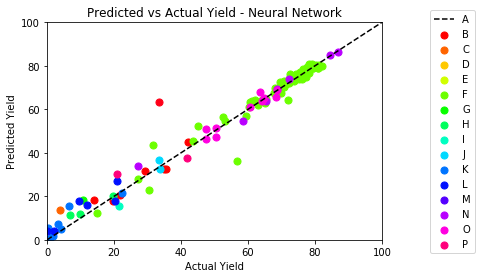

In [28]:
#Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


learningRates = [0.002, 0.005, 0.01, 0.02]
batchSizes = [64, 128, 256, 512, 1024]
dropoutRates = [0.00, 0.001, 0.01, 0.1]
errors = []

for lr_ in learningRates:
    for bs in batchSizes:
        for dr in dropoutRates:
            model = Sequential()
            model.add(Dense(units=12, activation='sigmoid', input_dim=13))
            model.add(Dropout(dr))
            model.add(Dense(units=12, activation='sigmoid'))
            model.add(Dense(units=6, activation='sigmoid'))
            model.add(Dense(units=6, activation='sigmoid'))
            model.add(Dense(units=1, activation='softplus'))

            sgd = SGD(lr=lr_)  
            model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

#             model.fit(X_train, y_train, sample_weight=train_weights, epochs=3000, batch_size=bs ,verbose=0)
            model.fit(X_train, y_train, epochs=3000, batch_size=bs ,verbose=0)


#             loss_and_metrics = model.evaluate(X_valid, y_valid, batch_size=bs)

            y_pred = model.predict(X_valid, batch_size=bs)
            y_pred = y_pred.flatten()

            error =  metrics.mean_absolute_error(y_valid, y_pred)
            errors.append(error)
            

index_of_lowest_error = np.argmin(errors)
print("Lowest Error In Validation _MSE_ ", np.min(errors))
    
best_lr = learningRates[int(index_of_lowest_error / (len(batchSizes) * len(dropoutRates)))] #Good
best_bs = batchSizes[int((index_of_lowest_error % (len(batchSizes) * len(dropoutRates)))/len(dropoutRates))] #Good
best_dr = dropoutRates[index_of_lowest_error % len(dropoutRates)] #Good 
print("Best Learning Rate is: ",best_lr)
print("Best Batch Size is: ", best_bs)
print("Best Dropout Rate is: ", best_dr)    

#Using best values

model = Sequential()
model.add(Dense(units=12, activation='sigmoid', input_dim=13))
model.add(Dropout(best_dr))
model.add(Dense(units=12, activation='sigmoid'))
model.add(Dense(units=6, activation='sigmoid'))
model.add(Dense(units=6, activation='sigmoid'))
model.add(Dense(units=1, activation='softplus'))

sgd = SGD(lr=best_lr)  
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights, epochs=3000, batch_size=best_bs ,verbose=0)

# loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

y_pred = model.predict(X_test, batch_size=bs)
y_pred = y_pred.flatten()


print('average', y_test.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

error_arr = abs(y_test - y_pred)
#plt.hist(error_arr)
#plt.scatter(y_test, y_pred)


for index, target in enumerate(targets):
    indicesToKeep = test_Frame['ID'] == target
    plt.scatter(y_test.values[indicesToKeep]
               , y_pred[indicesToKeep]
               , c = colors(index)
               , s = 50)
    
t = np.linspace(0, 100, 400)
line = t

    
plt.legend(targets, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.plot(t, line, 'k', ls='dashed')


# plt.ylim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
# plt.xlim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
plt.ylim(0, 100)
plt.xlim(0, 100)


plt.xlabel("Actual Yield")
plt.ylabel('Predicted Yield')
plt.title("Predicted vs Actual Yield - Neural Network")
plt.savefig("NN.png", dpi=600, bbox_inches='tight')


predAndActual = pd.DataFrame({'Pred' : y_pred, 'Test': y_test})
predAndActual.to_csv("OverallNN.csv")



In [10]:
##Testing Appropraite Parameter Selection

test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
for i in test:
    kern = int(i/(3 * 2 * 2))
    ep = int(i%(3*2*2)/(2*2))
    c = int((i%(2*2))/2)
    gam = i%2
    print(i,kern, ep, c, gam)

0 0 0 0 0
1 0 0 0 1
2 0 0 1 0
3 0 0 1 1
4 0 1 0 0
5 0 1 0 1
6 0 1 1 0
7 0 1 1 1
8 0 2 0 0
9 0 2 0 1
10 0 2 1 0
11 0 2 1 1
12 1 0 0 0
13 1 0 0 1
14 1 0 1 0
15 1 0 1 1
16 1 1 0 0
17 1 1 0 1
18 1 1 1 0
19 1 1 1 1
20 1 2 0 0
21 1 2 0 1
22 1 2 1 0
23 1 2 1 1


In [11]:
##Testing Appropraite Parameter Selection

test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
for i in test:
    kern = int(i/(3*4))
    ep = int(i%(3*4)/4)
    c = i % 4
    print(i,kern, ep, c)

0 0 0 0
1 0 0 1
2 0 0 2
3 0 0 3
4 0 1 0
5 0 1 1
6 0 1 2
7 0 1 3
8 0 2 0
9 0 2 1
10 0 2 2
11 0 2 3
12 1 0 0
13 1 0 1
14 1 0 2
15 1 0 3
16 1 1 0
17 1 1 1
18 1 1 2
19 1 1 3
20 1 2 0
21 1 2 1
22 1 2 2
23 1 2 3
